<a href="https://colab.research.google.com/github/albisbub/RFIC-Pitches/blob/master/_notebooks/2020-05-25-Macro-and-Holdings-Snapshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Historical Macroeconomic Data



This is a work in progress report that will give real time info on macroeconomic conditions, along with info on our holdings composition.

To Do:
- Github LIVE data updating
- Collect historical records of portfolio for returns analysis



## Imports and Helpers

In [0]:
#hide
#Requirements:
import warnings
warnings.filterwarnings('ignore')
!pip install requests bs4 pandas yahoofinancials yahoo_fin requests_html
!pip install argparse
!pip install matplotlib urllib3 seaborn
!pip install fuckit

     |████████████████████████████████| 153kB 5.0MB/s 
     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
  Created wheel for yahoofinancials: filename=yahoofinancials-1.5-cp36-none-any.whl size=15195 sha256=79d90085bc2f038caff1c36ebb2caa76b80a61d623ee5575e36bbc2c8009ce5a
  Stored in directory: /root/.cache/pip/wheels/42/15/e7/240c5cdc8782b9479ba73404640a3be57bb4053a5c3edd6be5
  Created wheel for parse: filename=parse-1.15.0-cp36-none-any.whl size=23710 sha256=2d226a7bc9fe780d1aaa86f90733b66066ab5ab15d7f4da2449b638c4d0d0e3b
  Stored in directory: /root/.cache/pip/wheels/07/ee/c8/eced0759f09fc635398ab1b8e89c38549b28e5db7fd4a53ba5
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp36-none-any.whl size=13484 sha256=20f1edf58775f66b0ff42728cd48a5a6d616b3dc2f7b1d9eda8ba2dc64a92c85
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
Successfully built yahoofinanci

  Created wheel for fuckit: filename=fuckit-4.8.1-cp36-none-any.whl size=5173 sha256=171dc4cd6e3f42c6cda4618e820191f5a00ceacaf7389e2d4c551ed139c5eb1a
  Stored in directory: /root/.cache/pip/wheels/a9/24/e6/a3e32536d1b2975c23ac9f6f1bdbc591d7b968e5e0ce6b4a4f
Successfully built fuckit


In [0]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from datetime import timedelta, datetime, date
%config InlineBackend.figure_format = 'retina'

chart_width = 550
chart_height= 400

import gspread
from oauth2client.service_account import ServiceAccountCredentials

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import requests
# !pip install 
from bs4 import BeautifulSoup
import pandas as pd
from yahoofinancials import YahooFinancials
from yahoo_fin.stock_info import get_quote_table, get_stats, get_live_price, get_income_statement, get_balance_sheet, get_cash_flow
# !pip install dict
# from dict import dict
def getQuote(ticker):
    return str(round(get_live_price(ticker), 2))

def finviz_summaryTable(symbols):
    # Get Column Header
    req = requests.get("https://finviz.com/quote.ashx?t=FB")
    soup = BeautifulSoup(req.content, 'html.parser')
    table = soup.find_all(lambda tag: tag.name=='table')
    rows = table[8].findAll(lambda tag: tag.name=='tr')
    out=[]
    for i in range(len(rows)):
        td=rows[i].find_all('td')
        out=out+[x.text for x in td]

    ls=['Ticker','Sector','Sub-Sector','Country']+out[::2]

    dict_ls={k:ls[k] for k in range(len(ls))}
    df=pd.DataFrame()
    print('Fetching Data...')
    for j in range(len(symbols)):

      try:

        req = requests.get("https://finviz.com/quote.ashx?t="+symbols[j])
        if req.status_code !=200:
            continue
        soup = BeautifulSoup(req.content, 'html.parser')
        table = soup.find_all(lambda tag: tag.name=='table')
        rows=table[6].findAll(lambda tag: tag.name=='tr')
        sector=[]
        for i in range(len(rows)):
            td=rows[i].find_all('td')
            sector=sector+[x.text for x in td]
        sector=sector[2].split('|')
        rows = table[8].findAll(lambda tag: tag.name=='tr')
        out=[]
        for i in range(len(rows)):
            td=rows[i].find_all('td')
            out=out+[x.text for x in td]
        out=[symbols[j]]+sector+out[1::2]
        out_df=pd.DataFrame(out).transpose()
        df=df.append(out_df,ignore_index=True)
        print('Done!')
        
        df=df.rename(columns=dict_ls)   

      except BaseException as E:
        print("Could not find data:", E)

    return(df)
    
def yf_summaryTable(tickerList):
    values = []
    for i in tickerList:
      try:
        value = get_quote_table(i , dict_result = True)
        values.append(value)
      except BaseException as e:
        print(e)
             
    outD = dict(zip(tickerList,values))
            
    return outD
        
def yf_stats_compTable(tickerList):
    values = []
    for i in tickerList:
      try:
        value = get_stats(i)
        values.append(value)
      except BaseException as e:
        print(e)
             
    outD= dict(zip(tickerList,values))
            
    return outD
               
def get_prices(tickerlist, start, end, period):
    yahoo_financials = YahooFinancials(tickerlist)
    jsonDATA = yahoo_financials.get_historical_price_data(start,end, period)
    return jsonDATA

In [0]:
#hide
def make_multi_LineGraph(data, logged):
  try:  
    df = data
    if logged == True:
      df['log Value'] =  np.around(np.log(df.Value), 4)
      aY = ('log Value:Q')
      scc = alt.Scale(type='linear')
      color1 = alt.Color('Metric:N', legend=alt.Legend(title="Natural Log of Metrics", labelFontSize=15, titleFontSize=17),
                      scale=alt.Scale(scheme='tableau20'))
    else:
      aY = ('Value:Q')
      scc=alt.Scale(type='linear')
      color1 = alt.Color('Metric:N', legend=alt.Legend(title="Metrics",labelFontSize=15, titleFontSize=17),
                      scale=alt.Scale(scheme='tableau20'))   
    label = alt.selection_multi(fields=['Metric'], bind='legend', 
        on='mouseover',  # select on mouseover events
        nearest=True,    # select data point nearest the cursor
        empty='none'     # empty selection includes no data points
    )
    # define our base line chart of stock prices
    base = alt.Chart().mark_line().encode(
        alt.X('date:T'),
        alt.Y(aY, scale=scc) ,
        color = color1 
        
        
        # alt.Color(' Metric:N'), opacity = alt.condition(label, alt.value(1), alt.value(0.5))

    )

    graph = alt.layer(
        base, # base line chart
        
        # add a rule mark to serve as a guide line
        alt.Chart().mark_rule(color='#aaa').encode(
            x='date:T'
        ).transform_filter(label),
        
        # add circle marks for selected time points, hide unselected points
        base.mark_circle().encode(
            opacity=alt.condition(label, alt.value(1), alt.value(0))
        ).add_selection(label),

        # add white stroked text to provide a legible background for labels
        base.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
            text=aY
        ).transform_filter(label),

        # add text labels for stock prices
        base.mark_text(align='left', dx=5, dy=-5).encode(
            text=aY
        ).transform_filter(label),
        
        data=df
    ).properties(
        width=700,
        height=400
    )
    
    return graph
  except BaseException as e:
    pass


def formatPeers(inputs):
  ColumnList = list(inputs.columns)
  yearList = list(inputs.Ticker)

  print(ColumnList)
  print(yearList)


  transposed = inputs.transpose()
  cleaned = transposed.reset_index()

  new_header = cleaned.iloc[0] #grab the first row for the header
  cleaned = cleaned[1:] #take the data less the header row
  cleaned.columns = new_header #set the header row as the df header

  byYear = cleaned.set_index("Ticker").stack()

  df = pd.DataFrame(byYear, columns=['Value'])
  df.reset_index(inplace=True)
  print(df.columns)
  df.rename(columns={0:'Ticker'}, inplace=True)
  df.dropna(inplace=True)
  df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

  new_header = df.iloc[0] #grab the first row for the header
  df = df[1:] #take the data less the header row
  df.columns = new_header #set the header row as the df header


  return df

def get_financials(tickerList):
  """
  list of lists
  same order as ticker list
  each list contains a list of datframes in the order income statement , balance sheet, cash flow
  """

  tickersDF = []
  for i in tickerList:

    income_statement = get_income_statement(i)
    
    balance_sheet = get_balance_sheet(i)
    
    cash_flow = get_cash_flow(i)

    finList = [income_statement, balance_sheet, cash_flow]
    tickersDF.append(finList)

  return tickersDF

def interactive_bat(data):


  source = data
  brush = alt.selection(type='interval', encodings=['x'])

  bars = alt.Chart().mark_bar().encode(
      x='Ticker:N',
      y='mean(Value):Q',
      opacity=alt.condition(brush, alt.OpacityValue(1), alt.OpacityValue(0.7)),
  ).add_selection(
      brush
  )

  line = alt.Chart().mark_rule(color='firebrick').encode(
      y='mean(Value):Q',
      size=alt.SizeValue(3)
  ).transform_filter(
      brush
  )

  graph = alt.layer(bars, line, data=source)

  return graph



def formatStmnt(inputs):
  ColumnList = list(inputs.columns)
  yearList = list(inputs.Year)

  # print(ColumnList)
  # print(yearList)


  # transposed = inputs.transpose()
  cleaned = inputs.rename_axis('Metric')
  # print(cleaned.columns)
  # cleaned.drop(cleaned.columns[0],inplace=True)
  byYear = cleaned.set_index('Year').stack()

  df = pd.DataFrame(byYear, columns=['Value'])
  df.reset_index(inplace=True)
  # print(df.columns)
  df.rename(columns={'row name':'Metric'}, inplace=True)
  # df.dropna(inplace=True)
  # df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
  # print(df)


  # print(df.columns)
  df = df[~df['Metric'].isin(['level_0','index'])]
  # df = df.drop(['level_0','index'],axis=0)
  # print(df.Year)

  df.Year = df.Year.astype(str)
  return df

In [0]:
#hide

#GETTING FRED DATA

# imports
import urllib.request as urlreq
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

% matplotlib inline

# takes FRED api arguments and returns the request
# FRED api documentation - https://research.stlouisfed.org/docs/api/fred/series.html
# api_key and series_id cannot be null
def get_FRED(api_key='c1890eec09036fa611becef53f435a65', file_type='json', series_id='', observation_start='', observation_end=''):
    
    # TO-DO
    # ensure series_id is not blank, since it has no default 
    #if series_id != '': 
    
    # set parameter strings, nulls will be not be included
    series_id = '&series_id=' + series_id
    file_type = '&file_type=' + file_type
    api_key = '&api_key=' + api_key
    if observation_start != '': observation_start = '&observation_start=' + observation_start
    if observation_end != '': observation_end = '&observation_end=' + observation_end
    
    # open url
    url_req_string = 'https://api.stlouisfed.org/fred/series/observations?'+ series_id + api_key + file_type + observation_start + observation_end
    url_response = urlreq.urlopen(url_req_string).read()
    url_data = json.loads(url_response)

    return pd.io.json.json_normalize(url_data, 'observations') 

In [36]:
#hide

def compile_FRED(series_names, series_ids, obs_start, obs_end):
  # series_names - a list of human readable terms for the data series (e.g. gdp)
  # series_ids - a list of the FRED ids corresponding to series_names
  # observation_start - formatted as YYYY-MM-DD
  # observation_end - formatted as YYYY-MM-DD
  
  # TO-DO
  # would be nice to have some control over observation dates between data series
  
  # output is a pandas df joined on observation dates and labeled with series_names
  macro_data = pd.DataFrame()
  
  for i in range(len(series_names)):
    if i == 0: # for the first series, establish dates, all other data series will be joined on these dates
      try:
        macro_data['date'], macro_data[series_names[i]] = get_FRED(series_id=series_ids[i], observation_start=obs_start, observation_end=obs_end)['date'], get_FRED(series_id=series_ids[i], observation_start=obs_start, observation_end=obs_end)['value'].astype(float)
      except BaseException as e:

        print(series_names[i], "THIS VARIABLES IS BROKENENENENENENEN")
        print(e)
    else: # for all other dates, get the data and join on first variable dates
      temp_data = pd.DataFrame()
      temp_data['date'], temp_data[series_names[i]] = get_FRED(series_id=series_ids[i], observation_start=obs_start, observation_end=obs_end)['date'], get_FRED(series_id=series_ids[i], observation_start=obs_start, observation_end=obs_end)['value'].astype(float)
      
      macro_data = macro_data.merge(temp_data[['date',series_names[i]]], how='inner', on='date')
      
  
  return macro_data
      
# # test function
# series_names = ['gdp_per_capita', 'unemployment_rate', 'cpi']
# series_ids = ['A939RX0Q048SBEA', 'UNRATE', 'CPIAUCSL']

from datetime import date
today = str(date.today().replace(day=1))
print(today)

# US_data = compile_FRED(series_names, series_ids, obs_start = '1950-01-01', obs_end = today)
# US_data.head()   

2020-05-01


### FRED Data Cleaning and Grouping

In [47]:
# exploring the basics, gdp, unemployment, and inflation
prices_n = [ 'cpi_inflation', 'gdp_deflator','cpi_urban','cpi_medical']
prices_id = ['CPIAUCSL',"FPCPITOTLZGUSA","A191RI1Q225SBEA","CPIMEDSL"]

fed_n = ["M1","M2","M2_less_M1","effective_ffr","ffr_upper","ffr_lower"]
fed_id = ["M1","M2","NONM1","DFF","DFEDTARU","DFEDTARL"]


output_n = ['potential_gdp','nominal_gdp','real_GDP']
output_id = ['GDPPOT','GDPC1','GDP']

per_cap_n = ['gdp_per_capita',]
per_cap_id = ['A939RX0Q048SBEA']

# employment_n = ['unemployment_rate',"fed_natural_rate",'insured_unemployment_rate','20_and_over', 'black_or_african_american','LNU04032183','women','men']
# employment_id = ['UNRATE',"NROU",'IURSA','LNS14000024','LNS14000006','LNU04032183','LNS14000002','LNS14000001']

# employment_n = ['unemployment_rate',"fed_natural_rate",'insured_unemployment_rate','20_and_over', 'black_or_african_american','LNU04032183','women','men']
# employment_id = ['UNRATE',"NROU",'IURSA','LNS14000024','LNS14000006','LNU04032183','LNS14000002','LNS14000001']

# employment_n = ['unemployment_rate',"fed_natural_rate",'insured_unemployment_rate',]
# employment_id = ['UNRATE',"NROU",'IURSA',]

employment_n = ['unemployment_rate',"fed_natural_rate",]
employment_id = ['UNRATE',"NROU",]



# 
# 1 Mo	2 Mo	3 Mo	6 Mo	1 Yr	2 Yr	3 Yr	5 Yr	7 Yr	10 Yr	20 Yr	30 Yr
yield_curve_n = ['DGS1MO',"DGS2MO","DGS6MO","DGS1","DGS2","DGS3","DGS5","DGS7","DGS10","DGS20","DGS30"]
yield_curve_id =  ['DGS1MO',"DGS2MO","DGS6MO","DGS1","DGS2","DGS3","DGS5","DGS7","DGS10","DGS20","DGS30"]



# yield_curve_n = ["DGS6MO","DGS1","DGS2","DGS3","DGS5","DGS7","DGS10","DGS20","DGS30"]
# yield_curve_id =  ['DGS1MO',"DGS2MO","DGS6MO","DGS1","DGS2","DGS3","DGS5","DGS7","DGS10","DGS20","DGS30"]


# print(len(series_names),len(series_ids))
prices =compile_FRED(prices_n, prices_id, obs_start = '1950-01-01', obs_end = today)
prices['cpi_inflation'] = prices['cpi_inflation'].pct_change() * 100
prices['cpi_medical'] = prices['cpi_medical'].pct_change() * 100

for i in prices.columns:
  print(i)
  if i != 'date':
    prices[i] = prices[i].round(2)  
# prices = prices.pct_change()
# prices['cpi_urban'] = prices['cpi_urban'].pct_change()

# prices['cpi_medical'] = prices['cpi_medical'].pct_change()

fed =compile_FRED(fed_n, fed_id, obs_start = '1950-01-01', obs_end = today)

output =compile_FRED(output_n, output_id, obs_start = '1950-01-01', obs_end = today)
pcap = compile_FRED(per_cap_n,per_cap_id, obs_start = '1950-01-01', obs_end = today)

for i in pcap.columns:
  print(i)
  if i != 'date':
    pcap[i] = ((pcap[i].pct_change())*100).round(2)

for i in output.columns:
  print(i)
  if i != 'date':
    output[i] = ((output[i].pct_change())*100).round(2)
    
employment =compile_FRED(employment_n, employment_id, obs_start = '1950-01-01', obs_end = today)

# yield_curve= compile_FRED(yield_curve_n, yield_curve_id, obs_start = '1950-01-01', obs_end = today)

macro_dfList = [prices,fed,output,pcap,employment]

# US_data.columns
# # add gdp per capital growth RATE, inflation RATE to the data set, as well as a flag for growth vs. recession per quarter
# US_data['gdp_growth_rate'] = US_data['gdp_per_capita'].pct_change()
# US_data['cpi_inflation_rate'] = US_data['cpi'].pct_change()

# US_data['growth'] = US_data['gdp_growth_rate'] > 0.0

# # drop null rows from the first period, which dont have percent changes
# US_data = US_data.dropna()

# US_data.head()

date
cpi_inflation
gdp_deflator
cpi_urban
cpi_medical
date
gdp_per_capita
date
potential_gdp
nominal_gdp
real_GDP


In [0]:
def formatMacros(inputs):
  ColumnList = list(inputs.columns)
  yearList = list(inputs.date)

  # print(ColumnList)
  # print(yearList)


  # transposed = inputs.transpose()
  cleaned = inputs.rename_axis('date')
  # print(cleaned.columns)
  # cleaned.drop(cleaned.columns[0],inplace=True)
  byYear = cleaned.set_index('date').stack()

  df = pd.DataFrame(byYear, columns=['Value'])
  # print(df)
  df.reset_index(inplace=True)
  # print(df.columns)
  df.rename(columns={'level_1':'Metric'}, inplace=True)
  # df.dropna(inplace=True)
  # df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
  # print(df)


  # print(df.columns)
  df = df[~df['date'].isin(['level_0','index'])]
  # df = df.drop(['level_0','index'],axis=0)
  # print(df.Year)

  df.Year = df.date.astype(str)
  return df
_prices = formatMacros(prices)

# Prices

Values are in **percents**, so a reading of 6 on the following chart is interpreted as ***6%***, *not 600%*.

## CPI Inflation Baskets

In [39]:
#hide-input
make_multi_LineGraph(_prices,False)

alt.LayerChart(...)

# Aggregate Demand

Y = (Consumption) + (Investment) + (Govt. Spending) - (Net Exports)

Percent Change

In [40]:
#hide-input

_output = formatMacros(output)
make_multi_LineGraph(_output,False)

alt.LayerChart(...)

Are we on a steady state growth path? 
Last 30 Years

In [41]:
#hide-input

import datetime
yearsago = str(datetime.datetime.now() - datetime.timedelta(days=30*365))
make_multi_LineGraph(_output[_output.date > yearsago],False)

alt.LayerChart(...)

In [42]:
#hide-input
make_multi_LineGraph(_output[_output.date > yearsago],True)

alt.LayerChart(...)

***Per Capita Output***

In [43]:
#hide-input

_pcap = formatMacros(pcap)
make_multi_LineGraph(_pcap,False)

alt.LayerChart(...)

In [44]:
make_multi_LineGraph(_pcap,True)

alt.LayerChart(...)

## Consumption

## Investment

## Governmtment Spending

## Exports/Imports

- Net Exports = Exports-Imports

# Aggregate Supply

## Productivity

## Input Markets

## Real Estate Markets

## Labor Markets

### Unemployment Rated

In [54]:
def gpct(input, logged,recent):
  
  _input = formatMacros(input)

  if recent:
    return make_multi_LineGraph(_input[_input.date > yearsago], logged)

  else:
      
    return make_multi_LineGraph(_input, logged)

gpct(employment, False, False)

alt.LayerChart(...)

In [51]:
gpct(employment, True,False)


alt.LayerChart(...)

In [55]:
gpct(employment, False, True)

alt.LayerChart(...)

In [56]:
gpct(employment, True, True)

alt.LayerChart(...)

## Credit Markets

## Capital Stock

# Fed Watching

## Balance Sheet

## Fed Funds Rate Targets

## Repurchase Activity

# Theoretical Relationships

## Classical Phillips Curve

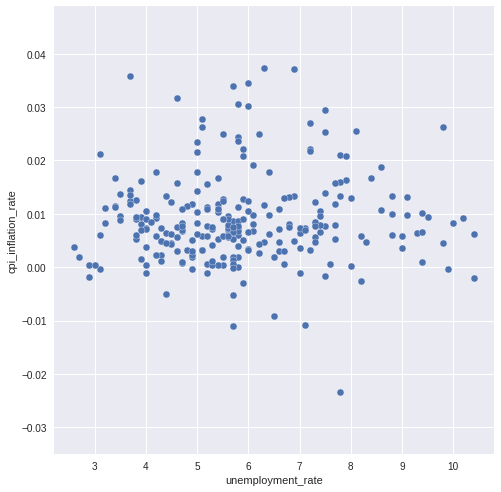

In [0]:
# explore some visualizations here

# let's take a look at a classic macro 101 relationship - the Phillips curve
# https://en.wikipedia.org/wiki/Phillips_curve
sns.pairplot(data=US_data, x_vars=['unemployment_rate'], y_vars=['cpi_inflation_rate'], size=7);

In [0]:
# doesnt seem to be much evidence of the Phillips curve in this correlation plot

In [0]:
# # try out some basic models on this data, attempting to predict if the US economy will grow or recede the next quarter (classification)

# # going to adjust the data a bit first, since we should be trying to predict with past data
# # each will have 4 lagged variables for unemployment rate, inflation rate, and gdp growth rate

# US_data_new = US_data.copy()

# # lagged unemployment
# US_data_new['unemployment_1'] = US_data_new['unemployment_rate'].shift(periods=1)
# US_data_new['unemployment_2'] = US_data_new['unemployment_rate'].shift(periods=2)
# US_data_new['unemployment_3'] = US_data_new['unemployment_rate'].shift(periods=3)
# US_data_new['unemployment_4'] = US_data_new['unemployment_rate'].shift(periods=4)

# # gdp lags
# US_data_new['gdp_1'] = US_data_new['gdp_growth_rate'].shift(periods=1)
# US_data_new['gdp_2'] = US_data_new['gdp_growth_rate'].shift(periods=2)
# US_data_new['gdp_3'] = US_data_new['gdp_growth_rate'].shift(periods=3)
# US_data_new['gdp_4'] = US_data_new['gdp_growth_rate'].shift(periods=4)

# # inflation lags
# US_data_new['cpi_1'] = US_data_new['cpi_inflation_rate'].shift(periods=1)
# US_data_new['cpi_2'] = US_data_new['cpi_inflation_rate'].shift(periods=2)
# US_data_new['cpi_3'] = US_data_new['cpi_inflation_rate'].shift(periods=3)
# US_data_new['cpi_4'] = US_data_new['cpi_inflation_rate'].shift(periods=4)

# # convert target to 0/1 instead of boolean
# US_data_new['growth'].replace(False, 0, inplace=True)

# # drop null rows for which we don't have new lagged variables
# US_data_new = US_data_new.dropna()

# # target and feature enumeration
# target = ['growth']
# features = ['unemployment_1', 'unemployment_2', 'unemployment_3', 'unemployment_4', 'gdp_1', 'gdp_2', 'gdp_3', 'gdp_4', 'cpi_1', 'cpi_2', 'cpi_3', 'cpi_4']

# # train test split
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(US_data_new, random_state=0)

# US_data_new.head()

,date,gdp_per_capita,unemployment_rate,cpi,gdp_growth_rate,cpi_inflation_rate,growth,unemployment_1,unemployment_2,unemployment_3,unemployment_4,gdp_1,gdp_2,gdp_3,gdp_4,cpi_1,cpi_2,cpi_3,cpi_4
5,1951-04-01,15968.0,3.1,25.92,0.013262,0.021277,1.0,3.7,4.2,5.0,5.8,0.009416,0.014557,0.034209,0.026846,0.035918,0.017865,0.017759,0.005955
6,1951-07-01,16223.0,3.1,25.91,0.015969,-0.000386,1.0,3.1,3.7,4.2,5.0,0.013262,0.009416,0.014557,0.034209,0.021277,0.035918,0.017865,0.017759
7,1951-10-01,16181.0,3.5,26.16,-0.002589,0.009649,0.0,3.1,3.1,3.7,4.2,0.015969,0.013262,0.009416,0.014557,-0.000386,0.021277,0.035918,0.017865
8,1952-01-01,16288.0,3.2,26.45,0.006613,0.011086,1.0,3.5,3.1,3.1,3.7,-0.002589,0.015969,0.013262,0.009416,0.009649,-0.000386,0.021277,0.035918
9,1952-04-01,16259.0,2.9,26.46,-0.001780,0.000378,0.0,3.2,3.5,3.1,3.1,0.006613,-0.002589,0.015969,0.013262,0.011086,0.009649,-0.000386,0.021277


# Modelling/Forecasting